## Implementation ml-task for package version

In [1]:
%env CUBLAS_WORKSPACE_CONFIG=:16:8

env: CUBLAS_WORKSPACE_CONFIG=:16:8


In [2]:
## Running Autoencodix training
import autoencodix as acx
from autoencodix.utils.default_config import DefaultConfig
from autoencodix.utils.default_config import DataCase
from autoencodix.data.datapackage import DataPackage
import pandas as pd

df_rna = pd.read_parquet("./input_data_test/combined_rnaseq_formatted.parquet")
df_meth = pd.read_parquet("./input_data_test/combined_meth_formatted.parquet")
df_anno = pd.read_parquet("./input_data_test/combined_clin_formatted.parquet")

data_package = DataPackage()
data_package.multi_bulk = {"transcriptomics": df_rna, "epigenetic": df_meth}
data_package.annotation = {
	"paired": df_anno.copy(),
}


my_cfg = DefaultConfig(
	data_case=DataCase.MULTI_BULK,
	loss_reduction="sum",
	k_filter=500,
	latent_dim=6,
	scaling="STANDARD",
	filtering="VAR",
	epochs=10,
	learning_rate=0.0005,
	batch_size = 128,
	beta = 0.5,
	drop_p =0.1,
	global_seed=42,
	checkpoint_interval=1,
	n_layers=1)

var = acx.Varix(data=data_package, config=my_cfg)
# var = acx.Vanillix(data=data_package, config=my_cfg)



/home/ewald/Github/autoencodix_package/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ewald/Github/autoencodix_package/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


in handle_direct_user_data with data: <class 'autoencodix.data.datapackage.DataPackage'>


In [3]:
var.run()

 n_samples: {'multi_sc': {'multi_sc': 0}, 'multi_bulk': {'transcriptomics': 3529, 'epigenetic': 3529}, 'annotation': {'paired': 3529}, 'img': {'img': 0}, 'from_modality': {}, 'to_modality': {}, 'paired_count': {'paired_count': 3529}}
cur shape: transcriptomics: (2470, 250)
cur shape: epigenetic: (2470, 250)
cur shape: transcriptomics: (706, 250)
cur shape: epigenetic: (706, 250)
cur shape: transcriptomics: (353, 250)
cur shape: epigenetic: (353, 250)


Result Object Public Attributes:
------------------------------
latentspaces: TrainingDynamics object
sample_ids: TrainingDynamics object
reconstructions: TrainingDynamics object
mus: TrainingDynamics object
sigmas: TrainingDynamics object
losses: TrainingDynamics object
sub_losses: LossRegistry(_losses={'recon_loss': TrainingDynamics(), 'var_loss': TrainingDynamics(), 'anneal_factor': TrainingDynamics(), 'effective_beta': TrainingDynamics()})
preprocessed_data: Tensor of shape (0,)
model: VarixArchitecture
model_checkpoints: TrainingDynamics object
datasets: DatasetContainer(train=<autoencodix.data._numeric_dataset.NumericDataset object at 0x7f1b9823c2b0>, valid=<autoencodix.data._numeric_dataset.NumericDataset object at 0x7f1b9823cca0>, test=<autoencodix.data._numeric_dataset.NumericDataset object at 0x7f1b9823ef80>)
new_datasets: DatasetContainer(train=None, valid=None, test=None)
adata_latent: AnnData object with n_obs × n_vars = 706 × 6
    uns: 'var_names'
final_reconstruction: <

In [4]:
## Evaluation
from sklearn import linear_model
sklearn_ml_class = linear_model.LogisticRegression(
							solver="sag",
							n_jobs=-1,
							class_weight="balanced",
							max_iter=200,
) ## Support of all sklearn-like models
sklearn_ml_regression = linear_model.LinearRegression()
own_metric_class = 'roc_auc_ovr'  ## sklearn name of metrics: https://scikit-learn.org/stable/modules/model_evaluation.html#string-name-scorers
own_metric_regression = 'r2' 

var.evaluate(
	ml_model_class=sklearn_ml_class, # Default is sklearn LogisticRegression
	ml_model_regression=sklearn_ml_regression, # Default is sklearn LinearRegression
	params= ["CANCER_TYPE", "AGE"],	# No default? ... or all params in annotation?
	metric_class = own_metric_class, # Default is 'roc_auc_ovr'
	metric_regression = own_metric_regression, # Default is 'r2'
	reference_methods = ["PCA", "UMAP", "RandomFeature"], # Default [], no references? or all possible? or only PCA?
	split_type = "use-split", # Default is "use-split", other options: "CV-5", ... "LOOCV"?

)

## Dataframe of evaluation results
print(var.result.embedding_evaluation)




Perform ML task with feature df: PCA


/home/ewald/Github/autoencodix_package/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ewald/Github/autoencodix_package/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


There are NA values in the annotation file. Samples with missing data will be removed for ML task evaluation.
Perform ML task with feature df: UMAP


/home/ewald/Github/autoencodix_package/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ewald/Github/autoencodix_package/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Perform ML task with feature df: RandomFeature


/home/ewald/Github/autoencodix_package/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ewald/Github/autoencodix_package/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Perform ML task with feature df: Latent
Perform ML task for target parameter: CANCER_TYPE
Perform ML task for target parameter: AGE


/home/ewald/Github/autoencodix_package/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  score_split CLINIC_PARAM       metric     value  \
0       train  CANCER_TYPE  roc_auc_ovr  0.998141   
1       valid  CANCER_TYPE  roc_auc_ovr  0.996514   
2        test  CANCER_TYPE  roc_auc_ovr  0.995050   
0       train          AGE           r2  0.076715   
1       valid          AGE           r2  0.092715   
2        test          AGE           r2  0.030402   
0       train  CANCER_TYPE  roc_auc_ovr  0.998672   
1       valid  CANCER_TYPE  roc_auc_ovr  0.992607   
2        test  CANCER_TYPE  roc_auc_ovr  0.995724   
0       train          AGE           r2  0.061697   
1       valid          AGE           r2  0.058133   
2        test          AGE           r2  0.029627   
0       train  CANCER_TYPE  roc_auc_ovr  0.911400   
1       valid  CANCER_TYPE  roc_auc_ovr  0.908566   
2        test  CANCER_TYPE  roc_auc_ovr  0.896749   
0       train          AGE           r2  0.031256   
1       valid          AGE           r2  0.034686   
2        test          AGE           r2  0.000

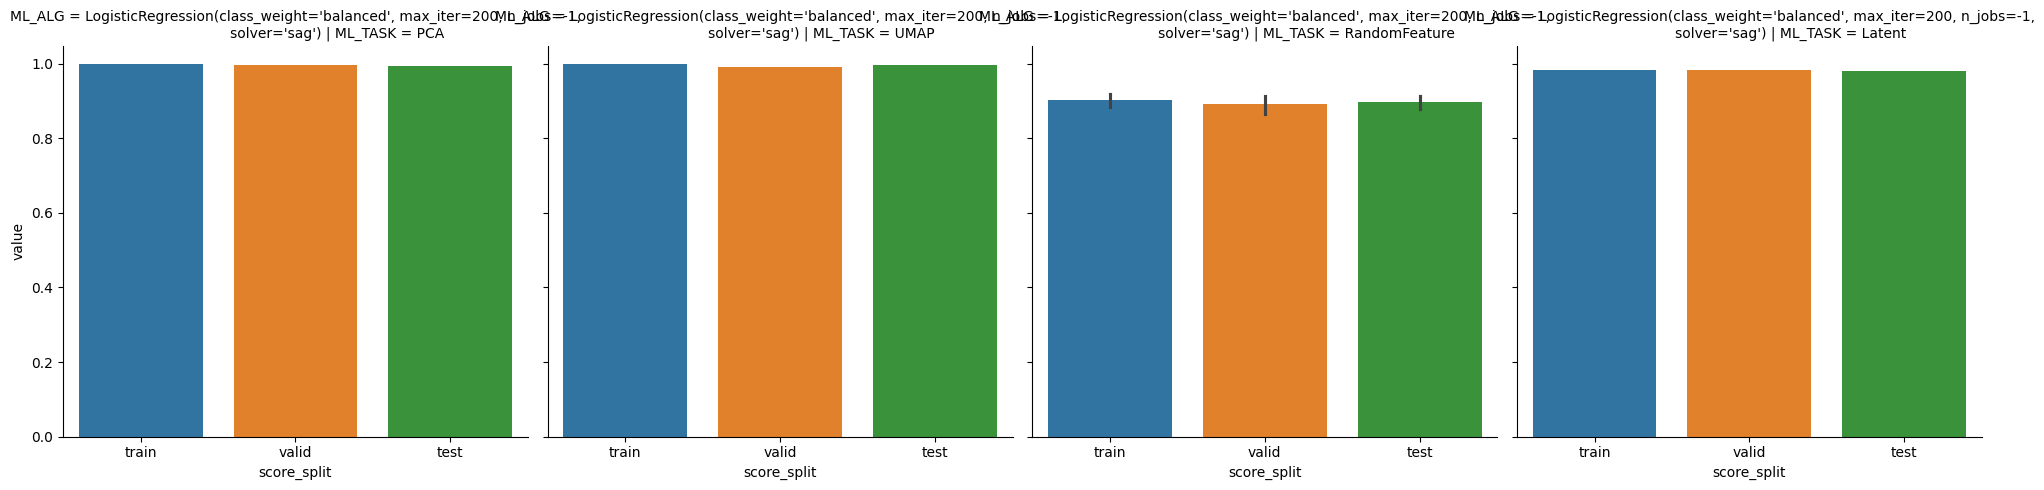

In [8]:
# barplot of evaluation results
var._visualizer.show_evaluation(
	param = "CANCER_TYPE",
	metric = own_metric_class, 
)

In [6]:
var.result.embedding_evaluation

,score_split,CLINIC_PARAM,metric,value,ML_ALG,ML_TYPE,ML_TASK,ML_SUBTASK
0,train,CANCER_TYPE,roc_auc_ovr,0.998141,"LogisticRegression(class_weight='balanced', ma...",classification,PCA,PCA
1,valid,CANCER_TYPE,roc_auc_ovr,0.996514,"LogisticRegression(class_weight='balanced', ma...",classification,PCA,PCA
2,test,CANCER_TYPE,roc_auc_ovr,0.995050,"LogisticRegression(class_weight='balanced', ma...",classification,PCA,PCA
0,train,AGE,r2,0.076715,LinearRegression(),regression,PCA,PCA
1,valid,AGE,r2,0.092715,LinearRegression(),regression,PCA,PCA
2,test,AGE,r2,0.030402,LinearRegression(),regression,PCA,PCA
0,train,CANCER_TYPE,roc_auc_ovr,0.998672,"LogisticRegression(class_weight='balanced', ma...",classification,UMAP,UMAP
1,valid,CANCER_TYPE,roc_auc_ovr,0.992607,"LogisticRegression(class_weight='balanced', ma...",classification,UMAP,UMAP
2,test,CANCER_TYPE,roc_auc_ovr,0.995724,"LogisticRegression(class_weight='balanced', ma...",classification,UMAP,UMAP
0,train,AGE,r2,0.061697,LinearRegression(),regression,UMAP,UMAP


In [7]:
var._visualizer.plots

defaultdict(<function autoencodix.utils._utils.nested_dict()>,
            {'ModelWeights': <Figure size 2000x1000 with 8 Axes>,
             'loss_absolute': <Figure size 1500x500 with 5 Axes>,
             'loss_relative': <Figure size 1500x500 with 2 Axes>,
             'ML_Evaluation': {'CANCER_TYPE': {'roc_auc_ovr': <seaborn.axisgrid.FacetGrid at 0x7f1a6c298d90>},
              'AGE': {'r2': <seaborn.axisgrid.FacetGrid at 0x7f1a661a2fb0>}}})